In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Change timestamp to ISO

In [2]:
# def preprocess_events_data(df):
#     """
#     Preprocesses the events DataFrame.
#     Converts 'timestamp' to datetime and creates a 'date' column.
#     """
#     df["ISO datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
#     df["date"] = df["ISO datetime"].dt.date
#     return df

# def preprocess_item_properties_data(df):
#     """
#     Preprocesses the item properties DataFrame.
#     Converts 'timestamp' to datetime and creates a 'date' column.
#     """
#     df["ISO datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
#     df["date"] = df["ISO datetime"].dt.date
#     return df

# # events = pd.read_csv("../dataset/events.csv")
# # events_processed = preprocess_events_data(events.copy())
# # events_processed.to_csv("../dataset/events_processed.csv", index=False)

# # item_properties_part_1_df = pd.read_csv("../dataset/item_properties_part1.csv")
# # item_properties_part_1_df_processed = preprocess_item_properties_data(item_properties_part_1_df.copy())

# # item_properties_part_2_df = pd.read_csv("../dataset/item_properties_part2.csv")
# # item_properties_part_2_df_processed = preprocess_item_properties_data(item_properties_part_2_df.copy())

# # item_properties_processed = pd.concat([item_properties_part_1_df_processed, item_properties_part_2_df_processed])
# # item_properties_processed.head()


In [3]:
try:
    event_df = pd.read_csv('../dataset/events.csv')
    item_df = pd.read_csv('../dataset/item_properties.csv')
    category_df = pd.read_csv('../dataset/category_tree.csv')
    print("Data Loaded Successfully!")
except FileNotFoundError:
    print("❌ File not found. Please check the path.")
    

Data Loaded Successfully!


## 1. Data cho K-means (cần RFM, conversion rate (category))

* Change property 790 to prices

In [4]:
prices = item_df[item_df['property'] == '790'].copy()
prices['price'] = prices['value'].apply(lambda x: float(x.replace('n', '')))
prices = prices[['itemid', 'timestamp', 'price']].sort_values('timestamp')


In [5]:
# ghép bảng giao dịch với giá tiền gần nhất trong bảng item
event_df = event_df.sort_values('timestamp')
event_df_price = pd.merge_asof(
    event_df,
    prices,
    left_on='timestamp',
    right_on='timestamp',
    by='itemid',
    direction='nearest', # Hoặc backward
    tolerance=pd.Timedelta('100000 days').value // 1000000 # convert days to ms nếu timestamp là ms
)
# thêm cột datetime, set time hiện tại = max + 1
if 'timestamp' in event_df_price.columns:
    event_df_price['datetime'] = pd.to_datetime(event_df_price['timestamp'], unit='ms')
current_date = event_df_price['datetime'].max() + pd.Timedelta(days=1)


* fill price = mean

In [6]:
global_avg_price = event_df_price['price'].mean()
event_df_price['price'] = event_df_price['price'].fillna(global_avg_price)

* Calculating R,F,M, prepare for K-means. Add more features 

In [7]:
event_df_price['is_view'] = (event_df_price['event'] == 'view').astype(int)
event_df_price['is_cart'] = (event_df_price['event'] == 'addtocart').astype(int)
event_df_price['is_buy']  = (event_df_price['event'] == 'transaction').astype(int)

# tính giá trị 
event_df_price['revenue'] = event_df_price['price'] * event_df_price['is_buy'] 
# event_df_price['view_value'] = event_df_price['price'] * event_df_price['is_view'] # Để tính trung bình giá các món họ xem
event_df_price.head(2)


,timestamp,visitorid,event,itemid,transactionid,price,datetime,is_view,is_cart,is_buy,revenue
0,1430622004384,693516,addtocart,297662,NaN,14280.0,2015-05-03 03:00:04.384,0,1,0,0.0
1,1430622011289,829044,view,60987,NaN,204120.0,2015-05-03 03:00:11.289,1,0,0,0.0


* Group infomation by visitor_id. Remove visitor no transactions

In [8]:
user_profile = event_df_price.groupby('visitorid').agg({
    'datetime': lambda x: (current_date - x.max()).days, # Recency (lần cuối tương tác bất kỳ)
    'is_view': 'sum',      # Tổng lượt xem
    'is_cart': 'sum',      # Tổng lượt thêm giỏ
    'is_buy': 'sum',       # Frequency (Số đơn mua)
    'revenue': 'sum',      # Monetary (Tổng tiền chi)
}).reset_index()


In [9]:
user_profile.columns = ['visitorid', 'Recency', 'View_Count', 'Cart_Count', 'Frequency', 'Monetary']
# recency là lần cuối tương tác bất kỳ, không nhất thiết phải mua

In [10]:
# Feature Enrichment: Tính các chỉ số phái sinh
# Conversion Rate: Tỷ lệ Mua / (Xem + Cart), smooth = +1
user_profile['Conversion_Rate'] = user_profile['Frequency'] / (user_profile['View_Count'] + user_profile['Cart_Count'] + 1)
user_profile.fillna(0, inplace=True)
print("Shape:", user_profile.shape)
user_profile[(user_profile['Frequency'] == 0) & (user_profile['Monetary'] != 0)]

Shape: (1407580, 7)


,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate


In [11]:
customers_df = user_profile[user_profile['Monetary'] > 0].copy()
visitors_df = user_profile[user_profile['Monetary'] <= 0].copy()
customers_df.reset_index(drop=True, inplace=True)
customers_df

,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate
0,172,35,33,3,2,99600.0,0.054054
1,186,37,2,1,1,59880.0,0.250000
2,264,11,3,2,2,94056.0,0.333333
3,419,51,4,1,1,17160.0,0.166667
4,539,94,4,2,1,34920.0,0.142857
...,...,...,...,...,...,...,...
11714,1406787,108,20,0,1,54000.0,0.047619
11715,1406981,123,4,1,1,143880.0,0.166667
11716,1407070,127,1,3,1,79080.0,0.200000
11717,1407110,45,7,1,1,20400.0,0.111111


In [12]:
cols_features = [
    'Recency', 
    'Frequency', 
    'Monetary', 
    'Conversion_Rate' 
]
print("Feature's Skewness")
print(customers_df[cols_features].skew())

Feature's Skewness
Recency             0.100507
Frequency          34.970714
Monetary           34.596136
Conversion_Rate     4.890277
dtype: float64


* Standarization

In [13]:
# Tạo copy để xử lý
customer_transformed = customers_df.copy()
id_col = 'visitor_id'

# Chọn các cột cần xử lý (Recency skew thấp rồi nhưng đưa vào PowerTransformer luôn cũng tốt, hoặc giữ nguyên)
# Ở đây ta ưu tiên xử lý 3 cột bị lệch
cols_to_fix = ['Frequency', 'Monetary', 'Conversion_Rate']

# Sử dụng Yeo-Johnson (Mặc định của sklearn, mạnh hơn Log, xử lý được cả số 0 và số âm nếu có)
pt = PowerTransformer(method='yeo-johnson', standardize=False) 

# Fit và transform
customer_transformed[cols_to_fix] = pt.fit_transform(customer_transformed[cols_to_fix])

print("--- Skewness sau khi dùng PowerTransformer ---")
print(customer_transformed[['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']].skew())
customer_transformed

--- Skewness sau khi dùng PowerTransformer ---
Recency            0.100507
Frequency          1.367438
Monetary           0.021475
Conversion_Rate    0.046189
dtype: float64


,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate
0,172,35,33,3,0.187039,5.533818,0.048844
1,186,37,2,1,0.182916,5.437255,0.164580
2,264,11,3,2,0.187039,5.523307,0.195533
3,419,51,4,1,0.182916,5.166875,0.124459
4,539,94,4,2,0.182916,5.326673,0.110836
...,...,...,...,...,...,...,...
11714,1406787,108,20,0,0.182916,5.416737,0.043536
11715,1406981,123,4,1,0.182916,5.599239,0.124459
11716,1407070,127,1,3,0.182916,5.490933,0.141810
11717,1407110,45,7,1,0.182916,5.207332,0.090866


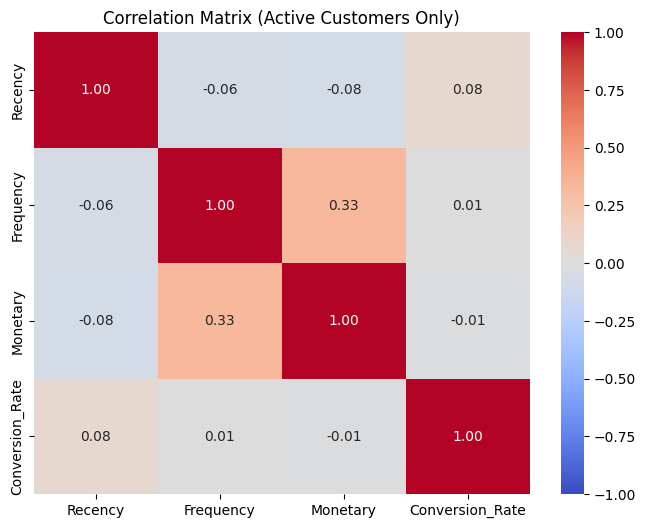

In [17]:
# 1. StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_transformed[cols_features])

# Chuyển lại thành DataFrame để vẽ cho dễ (và giữ tên cột)
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=cols_features,
    index=customer_transformed.index  # giữ alignment
)

# 2. Vẽ Heatmap Correlation
plt.figure(figsize=(8, 6))
corr_matrix = X_scaled_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Active Customers Only)")
plt.show()
X_scaled_df.insert(
    0,
    'visitorid',
    customer_transformed['visitorid'].values
)

In [19]:
X_scaled_df.to_csv('../dataset/user_scaled.csv', index=False)
customers_df.to_csv('../dataset/customers.csv', index=False)

## 2. Data cho CLV (cần RFM riêng)
